In [1]:
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from math import log,sqrt
%matplotlib inline
from wordcloud import WordCloud

In [2]:
msg=pd.read_csv("spam.csv",encoding='latin-1')
msg_orig=msg.copy()

In [3]:
msg.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
remove=msg.columns.values.tolist()[2:]

In [5]:
msg.drop(remove,axis=1,inplace=True)

In [6]:
msg.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
bl=(msg['v1']=='spam')
bl.head()

0    False
1    False
2     True
3    False
4    False
Name: v1, dtype: bool

In [8]:
msg['label']=0
msg.loc[bl,'label']=1

In [9]:
msg.head()

,v1,v2,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
msg.drop('v1',axis=1,inplace=True)
msg.rename(columns={'v2':'message'},inplace=True)
msg.shape

(5572, 2)

In [11]:
totalmsg=msg.shape[0]
trainIndex,testIndex=list(),list()
for i in range(totalmsg):
    if np.random.uniform(0,1)<.75:
        trainIndex+=[i]
    else:
        testIndex+=[i]
trainData=msg.loc[trainIndex]
testData=msg.loc[testIndex]

In [12]:
testData.reset_index(inplace=True)
trainData.reset_index(inplace=True)

In [13]:
trainData.drop('index',axis=1,inplace=True)
testData.drop('index',axis=1,inplace=True)

In [14]:
testData.head()

,message,label
0,Eh u remember how 2 spell his name... Yes i di...,0
1,Is that seriously how you spell his name?,0
2,Aft i finish my lunch then i go str down lor. ...,0
3,Just forced myself to eat a slice. I'm really ...,0
4,K tell me anything about you.,0


In [15]:
trainData.to_csv("train.csv")
testData.to_csv("test.csv")

In [16]:
trainData['label'].value_counts()

0    3610
1     553
Name: label, dtype: int64

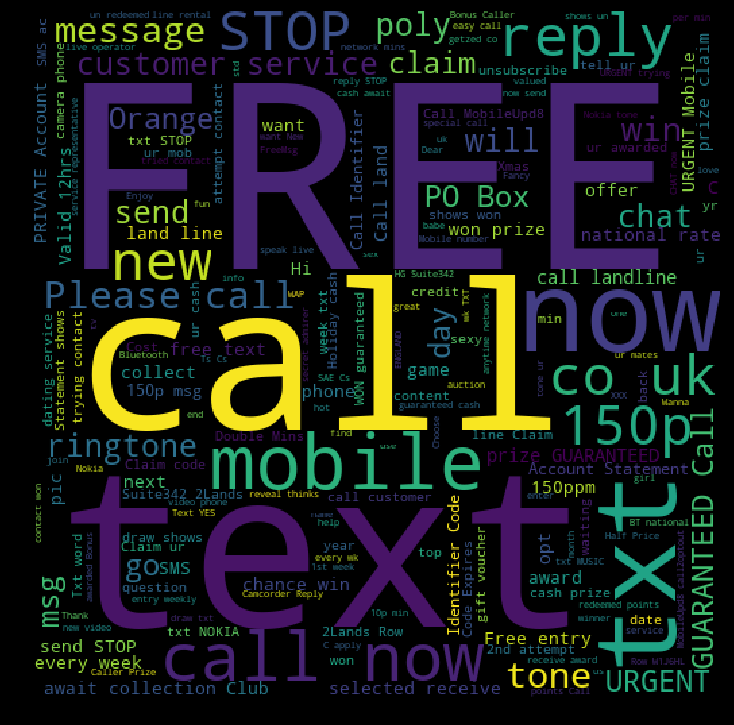

In [17]:
spam_words=' '.join(list(msg[msg['label']==1]['message']))
spam_wc=WordCloud(width=512,height=512).generate(spam_words)
plt.figure(figsize=(10,18),facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

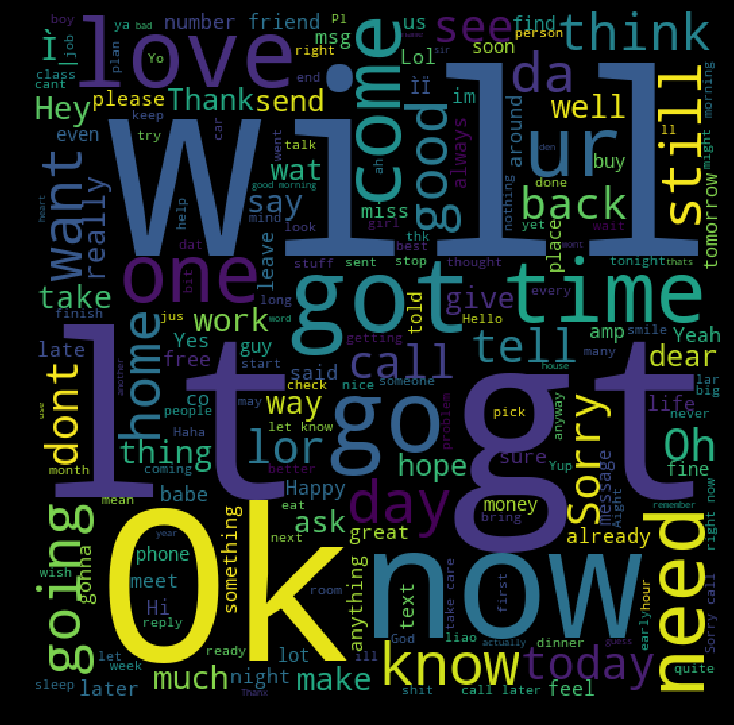

In [18]:
ham_words=' '.join(list(msg[msg['label']==0]['message']))
ham_wc=WordCloud(width=512,height=512)
ham_wc.generate(ham_words)
plt.figure(figsize=(10,18),facecolor='k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [19]:
def preprocess(message,lower_case=True,stem=True,stop_word=True,gram=2):
    if lower_case:
        message=message.lower()
    words=word_tokenize(message)
    words=[w for w in words if len(w)>2]
    if gram>1:
        w=[]
        for i in range(len(words)-gram+1):
            w+=[' '.join(words[i:i+gram])]
        words=w
    if stop_word:
        sw=stopwords.words('english')
        words=[w for w in words if w not in sw]
    if stem:
        stemmer=PorterStemmer()
        words=[stemmer.stem(word) for word in words]
        return words

In [36]:
def freq(data):
    d={}
    lis=preprocess(' '.join(list(data['message'])))
    for word in lis:
        if word in d:
            d[word]+=1
        else:
            d[word]=1
    df=pd.DataFrame.from_dict(d,orient='index')
    df.columns=['TF(w)']
    df['P(w)']=df['TF(w)']/df.shape[0]
    return df       

In [37]:
mails=freq(trainData)
spam_mail=freq(trainData.loc[trainData['label']==1])
ham_mail=freq(trainData.loc[trainData['label']==0])

In [38]:
num_spam=trainData['label'].value_counts()[1]
num_ham=trainData['label'].value_counts()[0]
p_spam=(num_spam)/(num_spam+num_ham)
p_ham=1-p_spam

In [52]:
def predict(message):
    token=preprocess(message)
    prob_spam=0
    prob_ham=0
    for word in token:
        if word in spam_mail.index.values.tolist():
            prob_spam+=log(spam_mail.loc[word,'P(w)'])
        elif word in ham_mail.index.values.tolist():
            prob_ham+=log(ham_mail.loc[word,'P(w)'])
    
    prob_spam+=log(p_spam)
    prob_ham+=log(p_ham)
    return prob_spam>prob_ham

In [53]:
out=testData['message'].apply(predict)


In [54]:
out.value_counts()

True     949
False    460
Name: message, dtype: int64